In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams["figure.figsize"] = (6,6)

In [3]:
import numpy as np
import pandas as pd

In [4]:
import tqdm
import pathlib

In [5]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

In [6]:
DATA_DIR = pathlib.Path("./")

In [7]:
RS = 283654

### Версии:

- `numpy`: 1.16.3
- `pandas`: 0.24.2
- `sklearn`: 0.21.2

# Загрузка данных

In [8]:
train_target = pd.read_csv(DATA_DIR.joinpath("rubber_target_train.csv"), index_col="date", parse_dates=["date"])
test_target = pd.read_csv(DATA_DIR.joinpath("rubber_test_timestamps.csv"), index_col="date", parse_dates=["date"])
data = pd.read_csv(DATA_DIR.joinpath("rubber_daily.csv"), index_col="date", parse_dates=["date"])

In [9]:
train_target.head()

,rubber
date,
2002-08-01,830.595238
2002-09-01,895.476190
2002-10-01,831.304348
2002-11-01,840.250000
2002-12-01,849.875000


In [10]:
data.head()

,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,USDTHB_mid,USDTHB_max,...,USDTHB_open,USDIDR_mid,USDIDR_max,USDIDR_min,USDIDR_open,USDVND_mid,USDVND_max,USDVND_min,USDVND_open,rubber_close
date,,,,,,,,,,,,,,,,,,,,,
2002-07-01,25.64,25.50,25.72,25.39,8.2770,8.2770,8.2770,8.2770,41.570,41.570,...,41.50,8710.0,8715.0,8669.0,8700.0,15297.5,NaN,NaN,NaN,835.0
2002-07-02,25.75,25.61,25.97,25.60,8.2769,8.2769,8.2769,8.2769,41.515,41.560,...,41.54,8805.0,8820.0,8720.0,8720.0,15297.0,NaN,NaN,NaN,827.5
2002-07-03,25.84,25.73,25.96,25.52,8.2768,8.2768,8.2768,8.2768,41.610,41.645,...,41.53,8965.0,8985.0,8790.0,8825.0,15297.5,NaN,NaN,NaN,847.5
2002-07-04,25.55,25.88,25.94,25.50,8.2767,8.2767,8.2767,8.2767,41.545,41.620,...,41.50,8855.0,8970.0,8790.0,8790.0,15298.5,NaN,NaN,NaN,847.5
2002-07-05,25.73,25.65,25.75,25.42,8.2766,8.2766,8.2766,8.2766,41.645,41.640,...,41.56,8860.0,8850.0,8815.0,8830.0,15295.0,NaN,NaN,NaN,847.5


In [11]:
test_target.head()

""
date
2016-01-01
2016-02-01
2016-03-01
2016-04-01
2016-05-01


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4221 entries, 2002-07-01 to 2019-06-28
Data columns (total 21 columns):
brent_close     4221 non-null float64
brent_open      4221 non-null float64
brent_max       4221 non-null float64
brent_min       4221 non-null float64
USDCNY_close    4221 non-null float64
USDCNY_open     4221 non-null float64
USDCNY_max      4221 non-null float64
USDCNY_min      4221 non-null float64
USDTHB_mid      4221 non-null float64
USDTHB_max      4220 non-null float64
USDTHB_min      4220 non-null float64
USDTHB_open     4220 non-null float64
USDIDR_mid      4219 non-null float64
USDIDR_max      4092 non-null float64
USDIDR_min      4092 non-null float64
USDIDR_open     4091 non-null float64
USDVND_mid      4209 non-null float64
USDVND_max      2675 non-null float64
USDVND_min      2675 non-null float64
USDVND_open     2674 non-null float64
rubber_close    4221 non-null float64
dtypes: float64(21)
memory usage: 725.5 KB


Text(0.5, 1, 'Rubber prices')

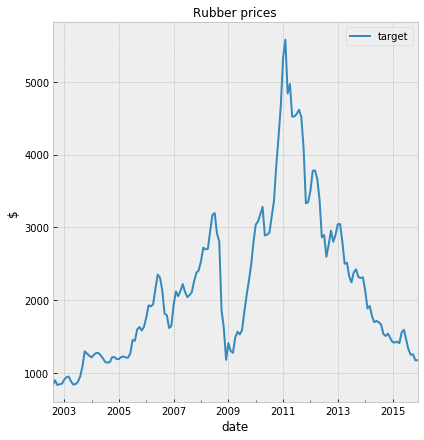

In [13]:
train_target["rubber"].plot(ax=plt.gca(), label="target")
plt.legend(loc=0)
plt.ylabel("$")
plt.tight_layout()
plt.title("Rubber prices", fontsize=12)

# Признаки

In [14]:
fts = data.resample("D").mean()

In [15]:
PERIODS = ["1D", "7D", "30D", "60D", "180D"]
AGGREGATES = ["mean", "median", "std", "max", "min"]

In [16]:
all_features = []

for period in tqdm.tqdm_notebook(PERIODS):
    for agg in AGGREGATES:
        if agg != "mean" and period == "1D":
            continue
        rolling_features = fts.rolling(period).aggregate(agg)
        rolling_features.rename(lambda x: "_".join([x, period, agg]), axis=1, inplace=True)
        all_features.append(rolling_features[rolling_features.index.day==9])

In [17]:
all_features = pd.concat(all_features, axis=1)

In [18]:
all_features.head()

,brent_close_1D_mean,brent_open_1D_mean,brent_max_1D_mean,brent_min_1D_mean,USDCNY_close_1D_mean,USDCNY_open_1D_mean,USDCNY_max_1D_mean,USDCNY_min_1D_mean,USDTHB_mid_1D_mean,USDTHB_max_1D_mean,...,USDTHB_open_180D_min,USDIDR_mid_180D_min,USDIDR_max_180D_min,USDIDR_min_180D_min,USDIDR_open_180D_min,USDVND_mid_180D_min,USDVND_max_180D_min,USDVND_min_180D_min,USDVND_open_180D_min,rubber_close_180D_min
date,,,,,,,,,,,,,,,,,,,,,
2002-07-09,25.17,25.10,25.20,24.75,8.2766,8.2766,8.2766,8.2766,41.265,41.45,...,41.42,8710.0,8715.0,8669.0,8700.0,15295.0,NaN,NaN,NaN,827.5
2002-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,NaN,NaN,NaN,772.5
2002-09-09,28.49,28.61,28.65,28.05,8.2770,8.2770,8.2770,8.2770,42.405,42.42,...,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,NaN,NaN,NaN,772.5
2002-10-09,28.13,28.09,28.40,27.87,8.2771,8.2771,8.2771,8.2771,43.680,43.75,...,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,NaN,NaN,NaN,772.5
2002-11-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,NaN,NaN,NaN,772.5


Выравниваем признаки к таргету:

In [19]:
all_features["prediction_date"] = (all_features.index
                                   + pd.TimedeltaIndex(all_features.index.days_in_month-8,
                                                       unit="D"))

Исключаем признаки, в которых слишком много `NaN`:

In [20]:
COLS = [col for col in all_features if ("USDVND_max" not in col
                                        and "USDVND_min" not in col
                                        and "USDVND_open" not in col)]
final_fts = all_features[COLS].ffill()

Формируем финальный датафрейм:

In [21]:
df = train_target.join(final_fts.set_index("prediction_date"), how="outer")
df.index.name = "date"
df.head()

,rubber,brent_close_1D_mean,brent_open_1D_mean,brent_max_1D_mean,brent_min_1D_mean,USDCNY_close_1D_mean,USDCNY_open_1D_mean,USDCNY_max_1D_mean,USDCNY_min_1D_mean,USDTHB_mid_1D_mean,...,USDTHB_mid_180D_min,USDTHB_max_180D_min,USDTHB_min_180D_min,USDTHB_open_180D_min,USDIDR_mid_180D_min,USDIDR_max_180D_min,USDIDR_min_180D_min,USDIDR_open_180D_min,USDVND_mid_180D_min,rubber_close_180D_min
date,,,,,,,,,,,,,,,,,,,,,
2002-08-01,830.595238,25.17,25.10,25.20,24.75,8.2766,8.2766,8.2766,8.2766,41.265,...,41.265,41.45,41.210,41.42,8710.0,8715.0,8669.0,8700.0,15295.0,827.5
2002-09-01,895.476190,25.17,25.10,25.20,24.75,8.2766,8.2766,8.2766,8.2766,41.265,...,40.395,40.45,40.195,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,772.5
2002-10-01,831.304348,28.49,28.61,28.65,28.05,8.2770,8.2770,8.2770,8.2770,42.405,...,40.395,40.45,40.195,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,772.5
2002-11-01,840.250000,28.13,28.09,28.40,27.87,8.2771,8.2771,8.2771,8.2771,43.680,...,40.395,40.45,40.195,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,772.5
2002-12-01,849.875000,28.13,28.09,28.40,27.87,8.2771,8.2771,8.2771,8.2771,43.680,...,40.395,40.45,40.195,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,772.5


Добавляем календарные признаки:

In [22]:
df["month"] = df.index.month
FTS_COLS = df.columns[1:]
TARGET = "rubber"

In [23]:
df.head()

,rubber,brent_close_1D_mean,brent_open_1D_mean,brent_max_1D_mean,brent_min_1D_mean,USDCNY_close_1D_mean,USDCNY_open_1D_mean,USDCNY_max_1D_mean,USDCNY_min_1D_mean,USDTHB_mid_1D_mean,...,USDTHB_max_180D_min,USDTHB_min_180D_min,USDTHB_open_180D_min,USDIDR_mid_180D_min,USDIDR_max_180D_min,USDIDR_min_180D_min,USDIDR_open_180D_min,USDVND_mid_180D_min,rubber_close_180D_min,month
date,,,,,,,,,,,,,,,,,,,,,
2002-08-01,830.595238,25.17,25.10,25.20,24.75,8.2766,8.2766,8.2766,8.2766,41.265,...,41.45,41.210,41.42,8710.0,8715.0,8669.0,8700.0,15295.0,827.5,8
2002-09-01,895.476190,25.17,25.10,25.20,24.75,8.2766,8.2766,8.2766,8.2766,41.265,...,40.45,40.195,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,772.5,9
2002-10-01,831.304348,28.49,28.61,28.65,28.05,8.2770,8.2770,8.2770,8.2770,42.405,...,40.45,40.195,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,772.5,10
2002-11-01,840.250000,28.13,28.09,28.40,27.87,8.2771,8.2771,8.2771,8.2771,43.680,...,40.45,40.195,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,772.5,11
2002-12-01,849.875000,28.13,28.09,28.40,27.87,8.2771,8.2771,8.2771,8.2771,43.680,...,40.45,40.195,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,772.5,12


# Модели

In [24]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

## Train/CV

In [25]:
tr = df[:"2013"].copy()
cv = df["2014":"2015"].copy()
ts = df["2016":].copy()

Text(0.5, 1, 'Rubber prices')

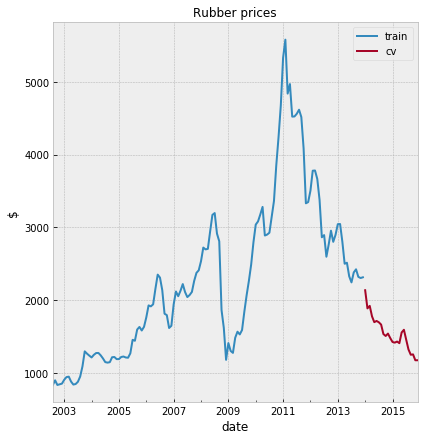

In [26]:
tr["rubber"].plot(ax=plt.gca(), label="train")
cv["rubber"].plot(ax=plt.gca(), label="cv")
plt.legend(loc=0)
plt.ylabel("$")
plt.tight_layout()
plt.title("Rubber prices", fontsize=12)

## Тривиальные бенчмарки

In [27]:
print(f"Naive benchmark (last known value): {100 * mape(cv[TARGET], tr.iloc[-1][TARGET]):0.1f}%")
print(f"Naive benchmark (TR period median): {100 * mape(cv[TARGET], tr[TARGET].median()):0.1f}%")

Naive benchmark (last known value): 53.6%
Naive benchmark (TR period median): 41.3%


In [28]:
naive_baseline = test_target.copy()
naive_baseline["rubber"] = df[TARGET].median()
naive_baseline.to_csv(DATA_DIR.joinpath("rubber_naive_baseline.csv"))

## Фильтруем признаки

In [29]:
corrs = tr.corr().loc["rubber", FTS_COLS[:-1]]

In [30]:
corrs.abs().sort_values(ascending=False).head(25)

rubber_close_7D_median      0.968383
rubber_close_7D_mean        0.968337
rubber_close_7D_max         0.968215
rubber_close_7D_min         0.967186
rubber_close_30D_min        0.962127
rubber_close_30D_mean       0.959973
rubber_close_30D_median     0.958078
rubber_close_30D_max        0.957488
rubber_close_1D_mean        0.956704
rubber_close_60D_min        0.949088
rubber_close_60D_mean       0.944412
rubber_close_60D_median     0.942929
rubber_close_60D_max        0.942380
rubber_close_180D_max       0.905469
rubber_close_180D_mean      0.890323
rubber_close_180D_min       0.888066
rubber_close_180D_median    0.877869
USDTHB_max_7D_median        0.831652
USDTHB_max_7D_mean          0.831088
USDTHB_max_7D_min           0.829730
USDTHB_max_7D_max           0.828958
USDTHB_open_7D_max          0.828657
USDTHB_max_1D_mean          0.828566
USDTHB_max_30D_max          0.827968
USDTHB_open_30D_max         0.827773
Name: rubber, dtype: float64

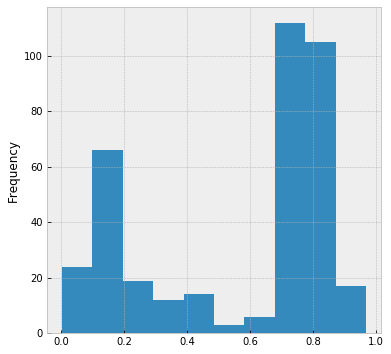

In [31]:
corrs.abs().plot(kind="hist")

Выбираем 50 признаков с наибольшей корреляцией:

In [32]:
FCOLS = corrs[corrs.abs()>=0.2].index

In [33]:
FCOLS

Index(['brent_close_1D_mean', 'brent_open_1D_mean', 'brent_max_1D_mean',
       'brent_min_1D_mean', 'USDCNY_close_1D_mean', 'USDCNY_open_1D_mean',
       'USDCNY_max_1D_mean', 'USDCNY_min_1D_mean', 'USDTHB_mid_1D_mean',
       'USDTHB_max_1D_mean',
       ...
       'USDCNY_close_180D_min', 'USDCNY_open_180D_min', 'USDCNY_max_180D_min',
       'USDCNY_min_180D_min', 'USDTHB_mid_180D_min', 'USDTHB_max_180D_min',
       'USDTHB_min_180D_min', 'USDTHB_open_180D_min', 'USDVND_mid_180D_min',
       'rubber_close_180D_min'],
      dtype='object', length=288)

## Линейная модель

Подбираем параметры:

In [34]:
params = ParameterGrid({"alpha":[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], "l1_ratio":[0.1, 0.25, 0.5, 0.75, 1.]})
errors = []

for param in params:
    lmodel = ElasticNet(alpha=param["alpha"], l1_ratio=param["l1_ratio"], random_state=RS)
    lmodel.fit(tr[FCOLS], tr[TARGET])

    ltr_preds = pd.Series(lmodel.predict(tr[FCOLS]), index=tr.index)
    lcv_preds = pd.Series(lmodel.predict(cv[FCOLS]), index=cv.index)

    cv_mape = mape(cv[TARGET], lcv_preds)
    errors.append({"mape":cv_mape, "alpha":param["alpha"], "l1_ratio":param["l1_ratio"]})

errors = pd.DataFrame.from_records(errors)

/home/traveller/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1541580.4332298634, tolerance: 16320.345978872765
  positive)
/home/traveller/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1522751.5818968634, tolerance: 16320.345978872765
  positive)
/home/traveller/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1482549.364766075, tolerance: 16320.345978872765
  positive)
/home/traveller/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase th

In [35]:
errors.iloc[errors["mape"].idxmin()]

alpha       10000.000000
l1_ratio        0.100000
mape            0.057146
Name: 35, dtype: float64

In [36]:
lmodel = ElasticNet(alpha=1e4, l1_ratio=0.1, random_state=RS)
lmodel.fit(tr[FCOLS], tr[TARGET])

/home/traveller/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 433020.0804671543, tolerance: 16320.345978872765
  positive)


ElasticNet(alpha=10000.0, copy_X=True, fit_intercept=True, l1_ratio=0.1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=283654, selection='cyclic', tol=0.0001,
           warm_start=False)

Визуализируем предсказания:

TR performance: 8.1%
CV performance: 5.7%


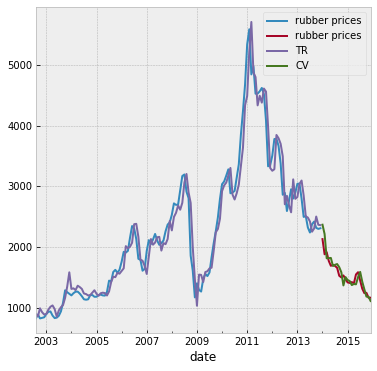

In [37]:
ltr_preds = pd.Series(lmodel.predict(tr[FCOLS]), index=tr.index)
lcv_preds = pd.Series(lmodel.predict(cv[FCOLS]), index=cv.index)

print(f"TR performance: {100 * mape(tr[TARGET], ltr_preds):0.1f}%")
print(f"CV performance: {100 * mape(cv[TARGET], lcv_preds):0.1f}%")

plt.figure()
tr[TARGET].plot(ax=plt.gca(), label="rubber prices");
cv[TARGET].plot(ax=plt.gca(), label="rubber prices");
ltr_preds.plot(ax=plt.gca(), label="TR");
lcv_preds.plot(ax=plt.gca(), label="CV");
plt.legend(loc=0);

Считаем предсказания для тестового набора:

In [38]:
ts_preds = pd.DataFrame(lmodel.predict(ts[FCOLS]), columns=["rubber"], index=ts.index)
ts_preds.loc[test_target.index].to_csv(DATA_DIR.joinpath("rubber_linear_baseline.csv"))